In [11]:
%matplotlib qt
import numpy as np
import matplotlib.pyplot as plt


In [24]:
class VegSim():
    
    def __init__(self):
        
        self.x = 0.0
        self.xd = 0.0
        self.z = 0.0
        self.zd = 0.0
        self.viscous_f = 4.0
        self.dt = 0.01
        self.max_z = 0.15
        self.max_x = 0.15
        self.noise_mul = 0.001
        self.step_size = 0.005
    
    
    def reset(self):
        
        self.x = 0.0
        self.xd = 0.0
        self.z = 0.0
        self.zd = 0.0
        self.viscous_f = 0.0
        self.dt = 0.01
        self.max_z = -0.15
        self.max_x = -0.15
        self.noise_mul = 0.005
        return [self.x, self.z, self.zd], False, False
        
    
    def action(self, f, xd):
        done_x = False 
        done_y = False 
        self.xd = xd
        if abs(f) > self.viscous_f:
            self.zd = np.sign(f)*(abs(f) + self.viscous_f)/150 + self.noise_mul * np.random.normal()
        else:
            self.zd = 0.0
        
        if self.z > self.max_z:
            self.z = self.z - self.zd * self.dt
        else:
            done_y = True
            
        if self.x > self.max_x:
            self.x = self.x + self.xd * self.dt
        else:
            done_x = True
        
        return [self.x, self.z, self.zd], done_x, done_y



In [85]:
class policy():
    
    def __init__(self):
        
        self.A = 0
        self.B = 1.0
        self.C = 2.0
        self.D = 0.0
        self.var = 0.1
        self.lr = 0.07
        
    
    def action(self, state):
        
        f = + self.C * (1 - state[2]) + self.B * (0.5 ** 2 - (0.5 - state[1])**2) \
            + self.A * state[0] 
        
        return np.random.normal(f, self.var), f
        
    
    def log_prob_grad(self, s):
        c = -((s[0] - s[1])*np.exp(-(s[0]-s[1])**2/(2 * self.var**2)))/(np.sqrt(2*np.pi)*self.var**2)
        
        grad = np.array([[s[2]],
                         [(0.25 - (0.5 - s[3])**2)],
                         [(1 - s[4])]])
        
        grad = grad * c 
        if np.linalg.norm(grad) > 1000:
            print (s)
        return grad
        
    def update(self, grad):
        
        self.A += grad[0] * self.lr
        self.B += grad[1] * self.lr
        self.C += grad[2] * self.lr
        


In [95]:
sim = VegSim()
p = policy()
state = sim.reset()
n_e = 40
n_rl = 10
step_size = 0.1
discount = 0.99
p.lr = 0.0002
xd = -0.02
max_z = -0.15
max_x = -0.15
final_reward = []
for e in range(n_e):
    data = []
    episode_data = []
    sim.reset()
    for rl in range(n_rl):
        rl_data = []
        state, done_x, done_y = sim.reset()
        previous_a = 0.0
        for i in range(1000):
            st = []
            ph_x = (state[0]) / max_x
            ph_z = (state[1]) / max_z
            st.append(xd)
            st.append(ph_x)
            st.append(ph_z)
            a, u = p.action(st)

            next_state, done_x, done_y = sim.action(a , xd)
            action_cost = (a**2)
#             print next_state[1]
            r = 1.0*(260 * (next_state[1]) / max_z \
                - 0.8 * action_cost)
            rl_data.append([u, a, st[0], st[1], st[2], r])
            state = next_state
            previous_a = a
        
        rl_data = np.array(rl_data)
        episode_data.append(rl_data)
    bar = np.zeros((3,1))
    b_sqr = np.zeros((3,1))
    baseline = np.zeros((3,1))
    reward_l = []
    bar_l = []
    b_l = []
    for r in episode_data:
        b = np.zeros((3,1))
        reward = 0.0
        for temp in range(rl_data.shape[0]):
            row = r[temp, :]
            b = b + p.log_prob_grad(row) 
            reward += (discount ** temp) * row[5]
        reward_l.append(reward)
        b_l.append(b)
        bar += (b ** 2) * reward 
        b_sqr += (b ** 2)
    if b_sqr[0] == 0.0 or b_sqr[1] == 0.0 or b_sqr[2] == 0.0:
        print ("invalid b")
    baseline[0] = bar[0] / b_sqr[0]
    baseline[1] = bar[1] / b_sqr[1]
    baseline[2] = bar[2] / b_sqr[2]
    grad0 = 0.0
    grad1 = 0.0
    grad2 = 0.0
    for n in range(len(reward_l)):
        grad0 += b_l[n][0,0]*(reward_l[n] - baseline[0,0])
        grad1 += b_l[n][1,0]*(reward_l[n] - baseline[1,0])
        grad2 += b_l[n][2,0]*(reward_l[n] - baseline[2,0])
    p.update(np.array([grad0, grad1, grad2]))
    print (grad0, grad1, grad2)
    final_reward.append(np.mean(reward_l))
# print (episode_data)


(58.104984324850022, 1310.6970295121971, 237.68637182662798)
(-143.8867461246613, -303.25638296137436, 5209.0857587206956)
(3.5658427994315502, -42.257277227779468, 1220.3885417149609)
(-31.384678141432829, -1050.2188361970939, -2348.9829779790052)
(-32.160604054257277, 130.82733395834492, 4831.0306563088707)
(-435.91146349258798, 3035.7971955367479, 11192.582440595741)
(-144.1972008253168, 284.55005055926716, 9313.9779427284284)
(142.56710378636501, -501.66722793760823, -1694.4181347188655)
(139.3090927325099, -2956.3240651047745, -3085.0555283487847)
(-122.2405081054583, 201.57624477102661, 2470.2382230436583)
(35.143727894450066, -81.83792917455844, -420.21367721701091)
(-69.977199441714262, 113.21320621367875, -1125.9523006229183)
(-13.929477933037372, 156.80852111240614, -1248.8301572071282)
(285.84943778518965, -309.09260185599447, -3574.3823447429509)
(-93.640684697463072, 893.18375934587664, 4107.5923516919911)
(108.01144987042598, -1535.0610344815245, 3723.504238984603)
(-47.8

In [96]:
plt.plot(final_reward)
plt.show()

In [97]:
plt.plot(episode_data[0][:,1])
plt.show()

In [98]:
plt.plot(episode_data[0][:,4])
plt.show()

In [90]:
print(p.A)
print(p.B)
print(p.C)
print(p.D)

-0.158772961372
3.99492055729
9.10589587531
0.0


### eNAC


In [217]:
sim = VegSim()
p = policy()
state = sim.reset()
n_e = 7
n_rl = 15
step_size = 0.04
discount = 0.99
xd = -0.02
max_z = -0.15
max_x = -0.15
final_reward = []
p.lr = 0.1
for e in range(n_e):
    data = []
    episode_data = []
    sim.reset()
    for rl in range(n_rl):
        rl_data = []
        state, done_x, done_y = sim.reset()
        previous_a = 0.0
        for i in range(800):
            st = []
            ph_x = (state[0]) / max_x
            ph_z = (state[1]) / max_z
            st.append(xd)
            st.append(ph_x)
            st.append(ph_z)
            a, u = p.action(st)
            next_state, done_x, done_y = sim.action(a, xd)
            if  abs(a) > 100:
                print(a)
                print(st)
            action_cost = (a**2)
            if not done_y:
                r = -1.0*( 2 * action_cost + 0.1*(next_state[1] - max_z)**2)
            else:
                r = 0
            rl_data.append([u, a, st[0], st[1], st[2], r])
            state = next_state
            previous_a = a
            if done_y:
                break
        rl_data = np.array(rl_data)
        episode_data.append(rl_data)
    bar = np.zeros((3,1))
    b_sqr = np.zeros((3,1))
    baseline = np.zeros((3,1))
    reward_l = []
    bar_l = []
    psi_sum_l = []
    vg_l = []
    for r in episode_data:
        psi_sum = np.zeros((3,1))
        reward = 0.0
        for temp in range(r.shape[0]):
            row = r[temp, :]
            psi_sum = psi_sum + p.log_prob_grad(row) 
            reward += (discount ** temp) * row[5]
        reward_l.append(reward)
        psi_sum_l.append(psi_sum)
        vg_l.append(psi_sum * reward)
    fisher_matrix = np.zeros((3, 3))
    vg = np.zeros((3, 1))
    eligibilty = np.zeros((3, 1))
    average_r = 0.0
    for i in range(len(reward_l)):
        fisher_matrix += psi_sum_l[i].dot(psi_sum_l[i].T)
        eligibilty += psi_sum_l[i]
        vg += vg_l[i]
    average_r = np.sum(reward_l) / n_rl
    fisher_matrix = fisher_matrix / n_rl
    eligibilty = eligibilty / n_rl
    vg = vg / n_rl

#     print(average_r)
#     print(fisher_matrix)
#     print(eligibilty)
#     print(vg)
    q = (1 + eligibilty.T.dot(np.linalg.pinv(n_rl*fisher_matrix - 
                                             eligibilty.dot(eligibilty.T))).dot(eligibilty))/n_rl
    b = q[0,0] * (average_r - eligibilty.T.dot(np.linalg.pinv(fisher_matrix).dot(vg)))
#     print()
    grad = np.linalg.pinv(fisher_matrix).dot((vg - eligibilty*b))
    print(grad)
#     print(q)
#     print(b)
    p.update(grad[:,0])
    final_reward.append(average_r)
#     print(grad)

[[-76584.26258193]
 [ 36235.20775918]
 [  1671.4687128 ]]
[[18945.79262715]
 [-7567.09559066]
 [ -516.00003441]]
[[ 289592.09851932]
 [-143759.13627025]
 [  -5757.84751013]]
-325.0800017349509
[-0.02, 0.004000000000000001, 0.7904420328785976]
-1296.755640174834
[-0.02, 0.005333333333333334, 2.953561653032065]
-326.49374719219486
[-0.02, 0.004000000000000001, 0.793291567326276]
-1302.9629385823516
[-0.02, 0.005333333333333334, 2.9669827308136205]
-315.48152543770095
[-0.02, 0.004000000000000001, 0.7695490555107004]
-1258.4083578009006
[-0.02, 0.005333333333333334, 2.8694802481604107]
-314.8430961477318
[-0.02, 0.004000000000000001, 0.7680329226775539]
-1255.7622316331433
[-0.02, 0.005333333333333334, 2.863378424467648]
-321.60747504782773
[-0.02, 0.004000000000000001, 0.7828839516840942]
-1283.153622263488
[-0.02, 0.005333333333333334, 2.9235332852672062]
-320.62634112439474
[-0.02, 0.004000000000000001, 0.7808326336503373]
-1279.1158396310664
[-0.02, 0.005333333333333334, 2.91460339491

OverflowError: (34, 'Numerical result out of range')

In [218]:
plt.plot(final_reward)
plt.show()

In [201]:
print(a)
print(state)

-0.3842787362216124
[-0.15000000000000224, -0.10485591614141651, 0.0]


In [202]:
plt.plot(episode_data[0][:,1])
plt.show()

In [186]:
print(p.A)
print(p.B)
print(p.C)

print(p.lr)
print(grad)

-421.1568875443968
295.17590079446404
16.24434108936362
0.1
[[-59.24320619]
 [ -5.53161595]
 [ -2.30698264]]


In [204]:
plt.plot(episode_data[0][:,4])
plt.show()

In [80]:
state = sim.reset()
for i in range(1000):
    sim.render()
    a, u = p.action(state)
    state = sim.action(a)

AttributeError: 'VegSim' object has no attribute 'render'

In [149]:
class gauss_policy():
    
    def __init__(self):
        
        self.A = 0.0
        self.B = 0.0
        self.C = 0.0
        self.D = 0.0
        self.var = 0.1
        self.lr = 0.07
        nbfs = 10
        self.w = np.ones(nbfs)*0.01
        self.centeres = np.linspace(0, 1, nbfs)
        self.width = 0.1
        
    def function_value(self, x):
        gauss = np.exp((-(self.centeres - x)**2)/(2*self.width**2))/((self.width**2) * np.sqrt(2*np.pi))
        return self.w.dot(gauss)
    
    def action(self, state):
        
        f = - self.C * (1 - state[2]) - self.B * (0.5 ** 2 - (0.5 - state[1])**2) \
            + self.A * state[0] 
        
        return np.random.normal(f, self.var), f
        
    
    def log_prob_grad(self, s):
        c = -((s[0] - s[1])*np.exp(-(s[0]-s[1])**2/(2 * self.var**2)))/(np.sqrt(2*np.pi)*self.var**2)
        
        grad = np.array([[s[2]],
                         [-(0.25 - (0.5 - s[3])**2)],
                         [-(1 - s[4])]])
        
        grad = grad * c 
        if np.linalg.norm(grad) > 1000:
            print (s)
        return grad
        
    def update(self, grad):
        
        self.A += grad[0] * self.lr
        self.B += grad[1] * self.lr
        self.C += grad[2] * self.lr
        




In [150]:
g = gauss_policy()

In [151]:
timme = np.linspace(0, 1, 100)
y = []
for t in timme:
    y.append(g.function_value(t))

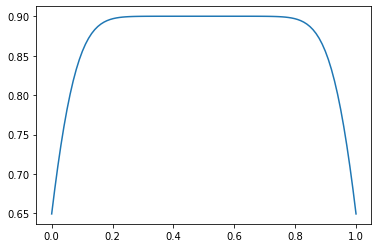

In [152]:
plt.plot(timme, y)